In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

2022-05-28 10:35:22.474216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-28 10:35:22.474269: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5

In [31]:
random.choices(labels, k=5)

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>]

In [27]:
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())
        print(self.labels)

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


In [28]:
import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

['617', '672', '325', '177', '247', '832', '824', '803', '294', '921', '609', '569', '20', '308', '395', '179', '573', '620', '551', '600', '204', '778', '217', '919', '751', '528', '382', '708', '524', '847', '35', '37', '41', '234', '267', '769', '881', '36', '652', '199', '591', '592', '674', '486', '497', '155', '111', '958', '754', '326', '706', '647', '788', '73', '130', '621', '537', '494', '934', '638', '896', '918', '776', '596', '332', '515', '646', '89', '729', '523', '742', '125', '670', '748', '678', '932', '272', '836', '945', '557', '796', '781', '12', '804', '744', '624', '119', '846', '608', '854', '837', '525', '483', '200', '777', '509', '659', '916', '540', '759', '632', '858', '189', '95', '963', '27', '154', '279', '588', '861', '880', '261', '310', '464', '175', '565', '521', '501', '213', '547', '433', '468', '723', '582', '137', '727', '567', '757', '139', '947', '726', '953', '649', '771', '407', '653', '599', '943', '779', '794', '147', '74', '867', '750', '7

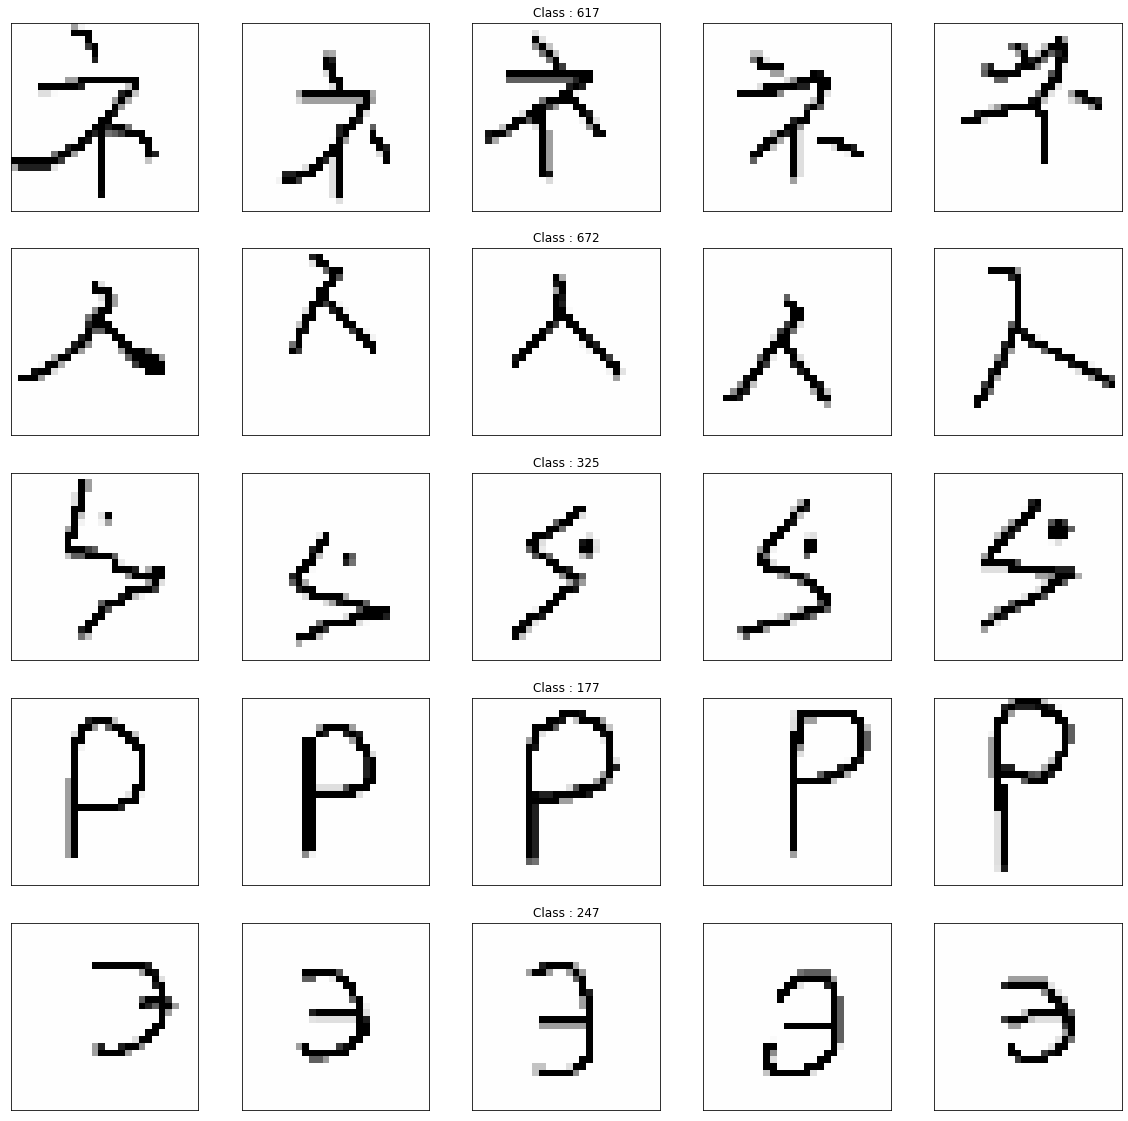

In [8]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
    for b in range(5):
        temp_image = train_dataset.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

In [9]:
def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)


In [22]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        print(labels)
        break
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )

tf.Tensor([1 1 0 2 3 0 2 4 0 4 2 3 1 3 1 1 4 4 4 1 3 1 1 2 3], shape=(25,), dtype=int32)
1/1 [==============================] - 0s 12ms/step
batch 0: train=1.000000 test=0.600000
tf.Tensor([4 2 2 2 3 0 4 3 0 2 1 0 0 0 1 3 1 0 2 1 0 4 4 2 2], shape=(25,), dtype=int32)
1/1 [==============================] - 0s 11ms/step
tf.Tensor([4 2 4 4 2 3 4 3 2 1 1 1 1 2 0 0 3 4 0 1 3 2 4 4 4], shape=(25,), dtype=int32)
1/1 [==============================] - 0s 11ms/step
tf.Tensor([3 1 3 1 4 0 3 1 0 3 2 0 0 3 0 3 2 3 1 1 2 2 0 0 4], shape=(25,), dtype=int32)
1/1 [==============================] - 0s 12ms/step
tf.Tensor([2 0 2 3 4 3 4 0 1 0 4 0 4 0 4 2 4 3 4 4 1 2 2 0 1], shape=(25,), dtype=int32)
1/1 [==============================] - 0s 12ms/step
tf.Tensor([0 1 4 2 4 3 0 3 4 1 3 4 0 0 0 1 3 2 0 0 1 1 3 0 4], shape=(25,), dtype=int32)
1/1 [==============================] - 0s 11ms/step
tf.Tensor([4 4 2 4 2 3 1 3 0 1 0 4 0 4 0 0 4 0 1 4 0 4 2 4 0], shape=(25,), dtype=int32)
1/1 [======================

KeyboardInterrupt: 

In [13]:
tfds.load("omniglot", split="small2", as_supervised=True, shuffle_files=False)

<PrefetchDataset element_spec=(TensorSpec(shape=(105, 105, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
for images, labels in mini_dataset:
    break

In [15]:
images.shape

TensorShape([25, 28, 28, 1])

In [16]:
labels.shape

TensorShape([25])

In [17]:
preds = model(images)

In [18]:
preds.shape

TensorShape([25, 5])

In [21]:
keras.losses.sparse_categorical_crossentropy(labels, preds)

<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([1.9235716 , 3.3748648 , 1.0147865 , 3.0546052 , 1.0147865 ,
       0.6430838 , 0.99476004, 2.2709763 , 1.0219028 , 1.4968102 ,
       2.097036  , 1.671476  , 1.972186  , 1.9084604 , 1.9192832 ,
       3.0546052 , 2.9377275 , 1.4968102 , 1.3239068 , 1.5131507 ,
       1.0227842 , 1.972186  , 1.5535084 , 1.1110704 , 3.374865  ],
      dtype=float32)>